In [62]:
import sys, os
ROOT = "/home/mb1921/ot-resampling/"
sys.path.insert(0, ROOT)

import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sampling_utils import (
    otc,
    compute_max_batch_size
)

In [63]:
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path1 = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BRS-BoN.csv"
    model_df1 = pd.read_csv(data_path1)
    model_dfs.append(model_df1)

df = pd.concat(model_dfs, ignore_index=True)
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1710,0.376509,2.0,0.0,BRS,ground_truth,0.662615,1
1,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1772,0.381838,3.0,0.0,BRS,ground_truth,0.662615,2
2,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1748,0.379796,4.0,0.0,BRS,ground_truth,0.662615,3
3,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1642,0.370457,5.0,0.0,BRS,ground_truth,0.662615,4
4,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1772,0.381838,6.0,0.0,BRS,ground_truth,0.662615,5
...,...,...,...,...,...,...,...,...,...,...,...
1011,5.182043,Qwen/Qwen3-14B,0.276199,0.5676,0.495409,3.0,0.0,BRS,estimate,0.685710,2
1012,5.182043,Qwen/Qwen3-14B,0.276199,0.6546,0.475499,4.0,0.0,BRS,estimate,0.685710,3
1013,5.182043,Qwen/Qwen3-14B,0.276199,0.4734,0.499292,2.0,0.0,BoN,estimate,0.685710,1
1014,5.182043,Qwen/Qwen3-14B,0.276199,0.5708,0.494962,3.0,0.0,BoN,estimate,0.685710,2


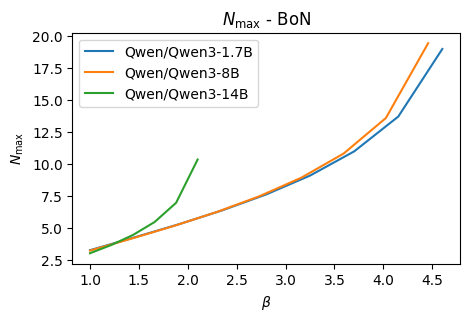

In [64]:
plt.figure(figsize=(5,3))
for model_id in model_ids:
    res_df = df[
        (df["model_id"]==model_id) &
        (df["mode"]=="ground_truth")
    ]
    betas = res_df["beta"].unique()
    s = res_df["s"].iloc[0]

    max_batch_sizes = []
    for beta in betas:
        max_batch_sizes.append(compute_max_batch_size(beta, s))

    
    plt.plot(betas, max_batch_sizes, label=model_id)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$N_{\rm max}$")
plt.title(r"$N_{\rm max}$ - BoN")
plt.legend()
plt.show()

/tmp/ipykernel_3226917/3435044007.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rocket_r", len(Ns))


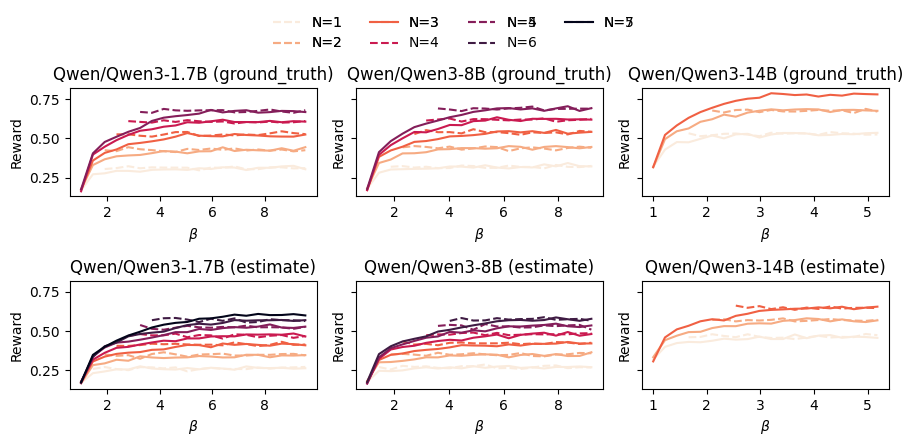

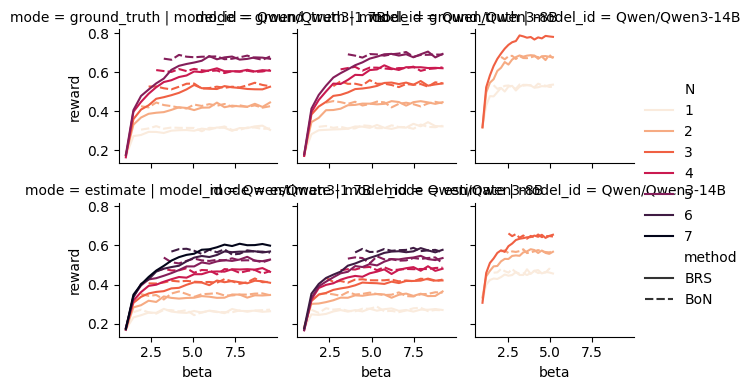

In [65]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Unique facets
modes = df["mode"].unique()
models = df["model_id"].unique()
methods = df["method"].unique()
Ns = sorted(df["N"].unique())

# Build color map for N (rocket_r in seaborn ~ reversed rocket colormap)
cmap = plt.cm.get_cmap("rocket_r", len(Ns))
color_map = {n: cmap(i) for i, n in enumerate(Ns)}

# Marker/linestyle map for methods
styles = ["-", "--", "-.", ":"]
style_map = {m: styles[i % len(styles)] for i, m in enumerate(methods)}

fig, axes = plt.subplots(len(modes), len(models),
                         figsize=(len(models)*3, len(modes)*2),
                         sharex=False, sharey=True)

if len(modes) == 1 and len(models) == 1:
    axes = np.array([[axes]])
elif len(modes) == 1:
    axes = axes[np.newaxis, :]
elif len(models) == 1:
    axes = axes[:, np.newaxis]

for i, mode in enumerate(modes):
    for j, model in enumerate(models):
        ax = axes[i, j]
        df_sub = df[(df["mode"] == mode) &
                           (df["model_id"] == model)]
        # Loop over groups
        for (n_val, method), df_group in df_sub.groupby(["N", "method"]):
            ax.plot(df_group["beta"], df_group["reward"],
                    linestyle=style_map[method],
                    color=color_map[n_val],
                    label=f"N={n_val}")
        
        ax.set_title(f"{model} ({mode})")
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel("Reward")
        #ax.legend(fontsize=8)

    # After plotting everything:
    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Deduplicate
    unique = dict(zip(labels, handles))

    # Place a single legend on top
    fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.5, 1.12),
            loc="upper center", ncol=4, frameon=False)

plt.tight_layout()
plt.show()

sns.relplot(
    data=df, 
    x="beta", 
    y="reward",
    hue="N",
    style="method",
    col="model_id",
    kind="line",
    height=2,
    row="mode",
    palette="rocket_r"
)

# Sub-optimality

In [66]:
def get_subopt_theory_fn_batch(s, shat, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        M = min(1/s, m/s) 
        return otc(beta, s)*((1-1/M)**N)
    return subopt_theory_fn

def get_subopt_theory_fn_batch_estimate(s, shat, J, N):
    def subopt_theory_fn(beta):
        m_star = s + np.sqrt(s*(1-s)*(beta-1))
        m_shat = shat + np.sqrt(shat*(1-shat)*(beta-1))
        M = min(1/shat, m_shat/shat) 
        alpha = 1 - (1-1/M)**N
        OTC = otc(beta, s)
        TPR = shat + (1 - s) * J
        
        # Transport regime
        if beta <= min(1/s, 1/shat):
            term = m_star/s - ( (m_shat*TPR)/(shat) + ((1-m_shat)*(1-TPR))/(1-shat) )
            suboptimality = (1-alpha)*OTC + alpha*s*term #( m_star/s - ( (m_shat*TPR)/shat + ((1-m_shat)*(1-TPR))/(1-shat)))

        # Policy Improvement regime
        elif min(1/shat, 1/s) < beta <= max(1/shat, 1/s):
            if shat > s:
                term = m_star/s - TPR/shat
            else:
                term = 1/s - ((m_shat*TPR)/shat + (((1-m_shat)*(1-TPR))/(1-shat)) )
            suboptimality = (1-alpha)*OTC + alpha*s*term
        
        # Saturation regime
        else: #beta > max(1/shat, 1/s):
            suboptimality = (1-alpha)*OTC + alpha*s*(1/s - TPR/shat)
        
        return suboptimality
    return subopt_theory_fn

def get_subopt_theory_fn_BoN(s, shat, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        return (1-s)**(N+1) - max(0, 1-m)
    return subopt_theory_fn

def get_subopt_theory_fn_BoN_estimate(s, shat, J, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        term1 = (1-s)*(1 - ((s)*(1-(1-shat)**N)*(J))/(shat))
        term2 = max(0, 1-m)
        return term1 - term2        
    return subopt_theory_fn

In [67]:
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}.csv"
    model_df = pd.read_csv(data_path)
    model_df = model_df[model_df["method"]=="SRS"]
    if "N" not in model_df.columns: model_df["N"] = np.nan
    model_dfs.append(model_df)

model_dfs.append(df)
df = pd.concat(model_dfs, ignore_index=True)
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1736,0.378765,1.0000,0.000000,SRS,ground_truth,0.662615,NaN
1,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1730,0.378247,1.0000,0.000000,SRS,estimate,0.662615,NaN
2,1.450358,Qwen/Qwen3-1.7B,0.170036,0.4382,0.496166,2.4876,1.920272,SRS,ground_truth,0.662615,NaN
3,1.450358,Qwen/Qwen3-1.7B,0.140030,0.3452,0.475433,2.6724,2.160990,SRS,estimate,0.662615,NaN
4,1.900716,Qwen/Qwen3-1.7B,0.170036,0.5296,0.499123,3.0434,2.507811,SRS,ground_truth,0.662615,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1131,5.182043,Qwen/Qwen3-14B,0.276199,0.5676,0.495409,3.0000,0.000000,BRS,estimate,0.685710,2.0
1132,5.182043,Qwen/Qwen3-14B,0.276199,0.6546,0.475499,4.0000,0.000000,BRS,estimate,0.685710,3.0
1133,5.182043,Qwen/Qwen3-14B,0.276199,0.4734,0.499292,2.0000,0.000000,BoN,estimate,0.685710,1.0
1134,5.182043,Qwen/Qwen3-14B,0.276199,0.5708,0.494962,3.0000,0.000000,BoN,estimate,0.685710,2.0


In [68]:
records = []

for model_id in model_ids:
    # Ground truth reference for all comparisons
    ref_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"] == "SRS")
    ].groupby(["beta"], as_index=False)["reward"].mean()
    
    for method in ["BoN", "BRS"]:
        # Get s, shat, J — only needed for BoN
        s = df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"] == method)
        ]["s"].iloc[0]

        shat = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"] == method)
        ]["s"].iloc[0]

        J = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"] == method)
        ]["J"].iloc[0]
        
        for mode in ["ground_truth", "estimate"]:
            query_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"] == method)
            ]

            for N in query_df["N"].unique():
                df_n = (
                    query_df[query_df["N"] == N]
                    .groupby("beta", as_index=False)["reward"].mean()
                )

                # Align on beta
                common = pd.merge(ref_df, df_n, on="beta", suffixes=("_ref", "_method"))
                subopt_emp = common["reward_ref"] - common["reward_method"]

                for beta, subopt in zip(common["beta"], subopt_emp):
                    records.append({
                        "model_id": model_id,
                        "mode": mode,
                        "method": method,
                        "N": N,
                        "beta": beta,
                        "subopt": subopt,
                        "subopt_type": "empirical"
                    })

                # Theory curves: only for BoN
                if method == "BoN":
                    betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
                    if mode == "ground_truth":
                        theory_fn = get_subopt_theory_fn_BoN(s, shat, N)
                    else:
                        theory_fn = get_subopt_theory_fn_BoN_estimate(s, shat, J, N)

                    subopt_theory = [theory_fn(b) for b in betas]
                    for beta, subopt in zip(betas, subopt_theory):
                        records.append({
                            "model_id": model_id,
                            "mode": mode,
                            "method": method,
                            "N": N,
                            "beta": beta,
                            "subopt": subopt,
                            "subopt_type": "theoretical"
                        })
                if method == "BRS":
                    betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
                    if mode == "ground_truth":
                        theory_fn = get_subopt_theory_fn_batch(s, shat, N)
                    else:
                        theory_fn = get_subopt_theory_fn_batch_estimate(s, shat, J, N)

                    subopt_theory = [theory_fn(b) for b in betas]
                    for beta, subopt in zip(betas, subopt_theory):
                        records.append({
                            "model_id": model_id,
                            "mode": mode,
                            "method": method,
                            "N": N,
                            "beta": beta,
                            "subopt": subopt,
                            "subopt_type": "theoretical"
                        })


# Build DataFrame
subopt_df = pd.DataFrame(records)
subopt_df

,model_id,mode,method,N,beta,subopt,subopt_type
0,Qwen/Qwen3-1.7B,ground_truth,BoN,1.0,1.900716,0.223800,empirical
1,Qwen/Qwen3-1.7B,ground_truth,BoN,1.0,2.351075,0.286800,empirical
2,Qwen/Qwen3-1.7B,ground_truth,BoN,1.0,2.801433,0.354400,empirical
3,Qwen/Qwen3-1.7B,ground_truth,BoN,1.0,3.251791,0.419400,empirical
4,Qwen/Qwen3-1.7B,ground_truth,BoN,1.0,3.702149,0.472200,empirical
...,...,...,...,...,...,...,...
6611,Qwen/Qwen3-14B,estimate,BRS,3.0,5.013072,0.354663,theoretical
6612,Qwen/Qwen3-14B,estimate,BRS,3.0,5.055315,0.354663,theoretical
6613,Qwen/Qwen3-14B,estimate,BRS,3.0,5.097557,0.354663,theoretical
6614,Qwen/Qwen3-14B,estimate,BRS,3.0,5.139800,0.354663,theoretical


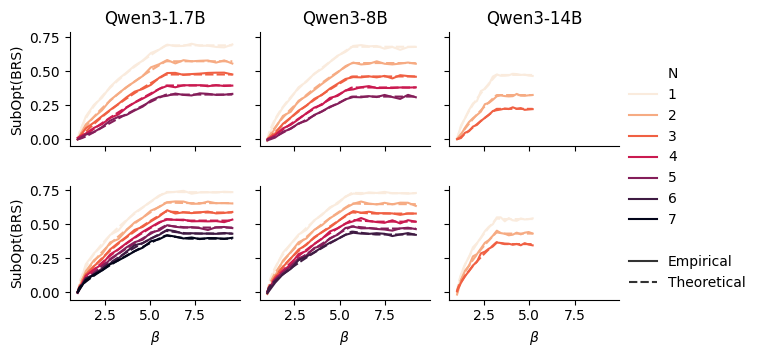

In [69]:
g = sns.relplot(
    data=subopt_df[subopt_df["method"] == "BRS"], 
    x="beta", 
    y="subopt",
    hue="N",
    style="subopt_type",
    col="model_id",
    kind="line",
    height=1.8,
    row="mode",
    palette="rocket_r",
    aspect=1.2
)
legend = g._legend
for text in legend.texts:
    label = text.get_text()
    new_label = label.replace("empirical", "Empirical").replace("theoretical", "Theoretical")
    text.set_text(new_label)

#g._legend.set_title(None)

def clean_title(title, i):
    # Example: "mode = ground_truth | model_id = Qwen/Qwen3-1.7B"
    if i<=2:
        if "model_id =" in title:
            model_path = title.split("model_id =")[-1].strip()
            model_name = model_path.split("/")[-1]
            return model_name
    else:
        return ""
    return title

# Apply custom title cleaning
for i, ax in enumerate(g.axes.flat):
    original_title = ax.get_title()
    ax.set_title(clean_title(original_title, i))

g.legend.handlelength = 0.5
for text in g.legend.texts:
    if text.get_text() == "subopt_type":
        text.set_visible(False)
    

for ax in g.axes.flat:
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"SubOpt(BRS)")

g.savefig(f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/subopt_qwen_BRS.pdf", bbox_inches="tight", dpi=300)

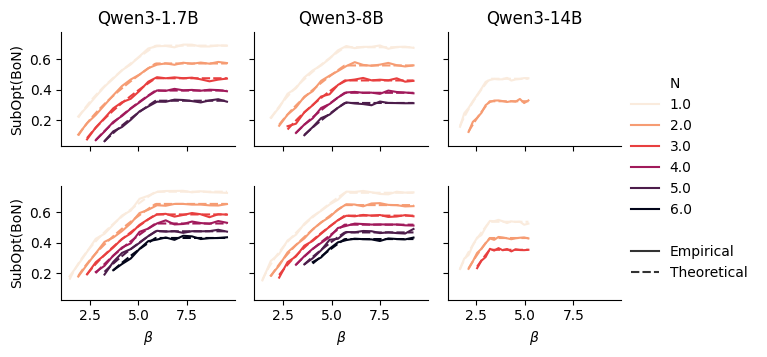

In [70]:
g = sns.relplot(
    data=subopt_df[subopt_df["method"] == "BoN"], 
    x="beta", 
    y="subopt",
    hue="N",
    style="subopt_type",
    col="model_id",
    kind="line",
    height=1.8,
    row="mode",
    palette="rocket_r",
    aspect=1.2
)
legend = g._legend
for text in legend.texts:
    label = text.get_text()
    new_label = label.replace("empirical", "Empirical").replace("theoretical", "Theoretical")
    text.set_text(new_label)

#g._legend.set_title(None)

def clean_title(title, i):
    # Example: "mode = ground_truth | model_id = Qwen/Qwen3-1.7B"
    if i<=2:
        if "model_id =" in title:
            model_path = title.split("model_id =")[-1].strip()
            model_name = model_path.split("/")[-1]
            return model_name
    else:
        return ""
    return title

# Apply custom title cleaning
for i, ax in enumerate(g.axes.flat):
    original_title = ax.get_title()
    ax.set_title(clean_title(original_title, i))

g.legend.handlelength = 0.5
for text in g.legend.texts:
    if text.get_text() == "subopt_type":
        text.set_visible(False)
    

for ax in g.axes.flat:
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"SubOpt(BoN)")

g.savefig(f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/subopt_qwen_BoN.pdf", bbox_inches="tight", dpi=300)

## Thresholding

In [71]:
user_id = "marcellobullo"
model_ids = ["google/gemma-3-4b-it", "meta-llama/Llama-3.1-8B-Instruct"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_threshold/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BRS-BoN-th{threshold[model_id]}.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)


model_ids = ["google/gemma-3-4b-it", "meta-llama/Llama-3.1-8B-Instruct"]

threshold = {
    "google/gemma-3-4b-it": 0.6,
    "meta-llama/Llama-3.1-8B-Instruct": 0.68
}

model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_threshold/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-th.csv"
    model_df = pd.read_csv(data_path)
    model_df = model_df[model_df["method"]=="SRS"]
    if "N" not in model_df.columns: model_df["N"] = np.nan
    model_dfs.append(model_df)

model_dfs.append(df)
df = pd.concat(model_dfs, ignore_index=True)
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,1.000000,google/gemma-3-4b-it,0.478547,0.4760,0.499424,1.0000,0.000000,SRS,ground_truth,0.554238,NaN
1,1.000000,google/gemma-3-4b-it,0.642445,0.4792,0.499567,1.0000,0.000000,SRS,estimate,0.554238,NaN
2,1.126089,google/gemma-3-4b-it,0.478547,0.6536,0.475822,1.3708,0.724505,SRS,ground_truth,0.554238,NaN
3,1.126089,google/gemma-3-4b-it,0.642445,0.5828,0.493097,1.2700,0.581636,SRS,estimate,0.554238,NaN
4,1.252178,google/gemma-3-4b-it,0.478547,0.7334,0.442181,1.5040,0.883393,SRS,ground_truth,0.554238,NaN
...,...,...,...,...,...,...,...,...,...,...,...
360,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.4848,0.499769,3.0000,0.000000,BoN,ground_truth,0.580397,2.0
361,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.5770,0.494035,4.0000,0.000000,BoN,ground_truth,0.580397,3.0
362,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.6756,0.468150,5.0000,0.000000,BoN,ground_truth,0.580397,4.0
363,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.531889,0.2878,0.452737,2.0000,0.000000,BRS,estimate,0.580397,1.0


In [72]:
model_ids = ["google/gemma-3-4b-it", "meta-llama/Llama-3.1-8B-Instruct"]

threshold = {
    "google/gemma-3-4b-it": 0.6,
    "meta-llama/Llama-3.1-8B-Instruct": 0.68
}

model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_threshold/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-th.csv"
    model_df = pd.read_csv(data_path)
    model_df = model_df[model_df["method"]=="SRS"]
    if "N" not in model_df.columns: model_df["N"] = np.nan
    model_dfs.append(model_df)

model_dfs.append(df)
df = pd.concat(model_dfs, ignore_index=True)
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,1.000000,google/gemma-3-4b-it,0.478547,0.4760,0.499424,1.0000,0.000000,SRS,ground_truth,0.554238,NaN
1,1.000000,google/gemma-3-4b-it,0.642445,0.4792,0.499567,1.0000,0.000000,SRS,estimate,0.554238,NaN
2,1.126089,google/gemma-3-4b-it,0.478547,0.6536,0.475822,1.3708,0.724505,SRS,ground_truth,0.554238,NaN
3,1.126089,google/gemma-3-4b-it,0.642445,0.5828,0.493097,1.2700,0.581636,SRS,estimate,0.554238,NaN
4,1.252178,google/gemma-3-4b-it,0.478547,0.7334,0.442181,1.5040,0.883393,SRS,ground_truth,0.554238,NaN
...,...,...,...,...,...,...,...,...,...,...,...
440,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.4848,0.499769,3.0000,0.000000,BoN,ground_truth,0.580397,2.0
441,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.5770,0.494035,4.0000,0.000000,BoN,ground_truth,0.580397,3.0
442,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.201738,0.6756,0.468150,5.0000,0.000000,BoN,ground_truth,0.580397,4.0
443,8.054986,meta-llama/Llama-3.1-8B-Instruct,0.531889,0.2878,0.452737,2.0000,0.000000,BRS,estimate,0.580397,1.0


In [73]:
records = []

for model_id in model_ids:
    # Ground truth reference for all comparisons
    ref_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"] == "SRS")
    ].groupby(["beta"], as_index=False)["reward"].mean()
    
    for method in ["BoN", "BRS"]:
        # Get s, shat, J — only needed for BoN
        s = df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"] == method)
        ]["s"].iloc[0]

        shat = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"] == method)
        ]["s"].iloc[0]

        J = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"] == method)
        ]["J"].iloc[0]
        
        for mode in ["ground_truth", "estimate"]:
            query_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"] == method)
            ]

            for N in query_df["N"].unique():
                df_n = (
                    query_df[query_df["N"] == N]
                    .groupby("beta", as_index=False)["reward"].mean()
                )

                # Align on beta
                common = pd.merge(ref_df, df_n, on="beta", suffixes=("_ref", "_method"))
                subopt_emp = common["reward_ref"] - common["reward_method"]

                for beta, subopt in zip(common["beta"], subopt_emp):
                    records.append({
                        "model_id": model_id,
                        "mode": mode,
                        "method": method,
                        "N": N,
                        "beta": beta,
                        "subopt": subopt,
                        "subopt_type": "empirical"
                    })

                # Theory curves: only for BoN
                if method == "BoN":
                    betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
                    if mode == "ground_truth":
                        theory_fn = get_subopt_theory_fn_BoN(s, shat, N)
                    else:
                        theory_fn = get_subopt_theory_fn_BoN_estimate(s, shat, J, N)

                    subopt_theory = [theory_fn(b) for b in betas]
                    for beta, subopt in zip(betas, subopt_theory):
                        records.append({
                            "model_id": model_id,
                            "mode": mode,
                            "method": method,
                            "N": N,
                            "beta": beta,
                            "subopt": subopt,
                            "subopt_type": "theoretical"
                        })
                if method == "BRS":
                    betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
                    if mode == "ground_truth":
                        theory_fn = get_subopt_theory_fn_batch(s, shat, N)
                    else:
                        theory_fn = get_subopt_theory_fn_batch_estimate(s, shat, J, N)

                    subopt_theory = [theory_fn(b) for b in betas]
                    for beta, subopt in zip(betas, subopt_theory):
                        records.append({
                            "model_id": model_id,
                            "mode": mode,
                            "method": method,
                            "N": N,
                            "beta": beta,
                            "subopt": subopt,
                            "subopt_type": "theoretical"
                        })


# Build DataFrame
subopt_df = pd.DataFrame(records)
subopt_df

,model_id,mode,method,N,beta,subopt,subopt_type
0,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.126089,-0.060200,empirical
1,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.252178,-0.002600,empirical
2,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.378268,0.054200,empirical
3,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.504357,0.087800,empirical
4,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.630446,0.143800,empirical
...,...,...,...,...,...,...,...
1780,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.769936,0.704794,theoretical
1781,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.841198,0.704794,theoretical
1782,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.912461,0.704794,theoretical
1783,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.983723,0.704794,theoretical


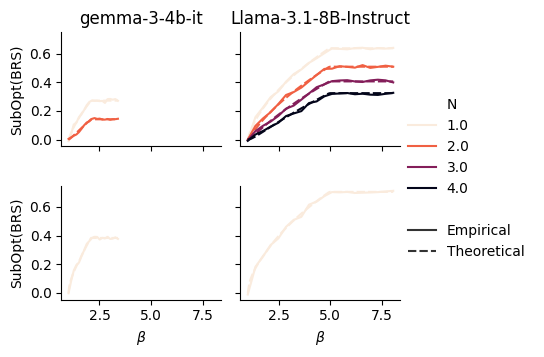

In [77]:
g = sns.relplot(
    data=subopt_df[subopt_df["method"] == "BRS"], 
    x="beta", 
    y="subopt",
    hue="N",
    style="subopt_type",
    col="model_id",
    kind="line",
    height=1.8,
    row="mode",
    palette="rocket_r",
    aspect=1.2
)
legend = g._legend
for text in legend.texts:
    label = text.get_text()
    new_label = label.replace("empirical", "Empirical").replace("theoretical", "Theoretical")
    text.set_text(new_label)

#g._legend.set_title(None)

def clean_title(title, i):
    # Example: "mode = ground_truth | model_id = Qwen/Qwen3-1.7B"
    if i<=1:
        if "model_id =" in title:
            model_path = title.split("model_id =")[-1].strip()
            model_name = model_path.split("/")[-1]
            return model_name
    else:
        return ""
    return title

# Apply custom title cleaning
for i, ax in enumerate(g.axes.flat):
    original_title = ax.get_title()
    ax.set_title(clean_title(original_title, i))

g.legend.handlelength = 0.5
for text in g.legend.texts:
    if text.get_text() == "subopt_type":
        text.set_visible(False)
    

for ax in g.axes.flat:
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"SubOpt(BRS)")

g.savefig(f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/subopt_threshold_BRS.pdf", bbox_inches="tight", dpi=300)

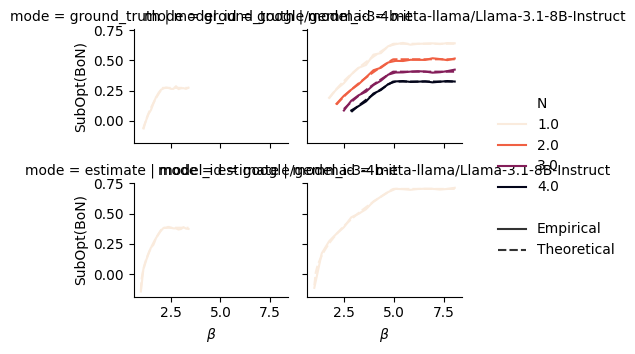

In [ ]:
g = sns.relplot(
    data=subopt_df[subopt_df["method"] == "BoN"], 
    x="beta", 
    y="subopt",
    hue="N",
    style="subopt_type",
    col="model_id",
    kind="line",
    height=1.8,
    row="mode",
    palette="rocket_r",
    aspect=1.2
)
legend = g._legend
for text in legend.texts:
    label = text.get_text()
    new_label = label.replace("empirical", "Empirical").replace("theoretical", "Theoretical")
    text.set_text(new_label)

#g._legend.set_title(None)

def clean_title(title, i):
    # Example: "mode = ground_truth | model_id = Qwen/Qwen3-1.7B"
    if i<=1:
        if "model_id =" in title:
            model_path = title.split("model_id =")[-1].strip()
            model_name = model_path.split("/")[-1]
            return model_name
    else:
        return ""
    return title

# Apply custom title cleaning
for i, ax in enumerate(g.axes.flat):
    original_title = ax.get_title()
    ax.set_title(clean_title(original_title, i))

g.legend.handlelength = 0.5
for text in g.legend.texts:
    if text.get_text() == "subopt_type":
        text.set_visible(False)
    

for ax in g.axes.flat:
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"SubOpt(BoN)")

g.savefig(f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/subopt_threshold_BoN.pdf", bbox_inches="tight", dpi=300)

In [79]:
subopt_df

,model_id,mode,method,N,beta,subopt,subopt_type
0,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.126089,-0.060200,empirical
1,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.252178,-0.002600,empirical
2,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.378268,0.054200,empirical
3,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.504357,0.087800,empirical
4,google/gemma-3-4b-it,ground_truth,BoN,1.0,1.630446,0.143800,empirical
...,...,...,...,...,...,...,...
1780,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.769936,0.704794,theoretical
1781,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.841198,0.704794,theoretical
1782,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.912461,0.704794,theoretical
1783,meta-llama/Llama-3.1-8B-Instruct,estimate,BRS,1.0,7.983723,0.704794,theoretical
